In [87]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta, date
from configparser import SectionProxy
from logging import Logger
import logging

from typing import Mapping, Optional, Dict, List, Tuple

link = 'https://andelenergi.dk/?obexport_format=csv&obexport_start=2022-08-10&obexport_end=2022-08-18&obexport_region=east'

region = 'east'
transport_overhead = 1.59 #DKK

logger = logging.getLogger(__name__)
logger.info('Getting price data')

def make_El_price_URL(start_date: date, end_date: date, region: str) -> str:
    url = 'https://andelenergi.dk/?obexport_format=csv&obexport_start='+str(start_date)+'&obexport_end='+str(end_date)+'&obexport_region='+region
    return url

def get_price_csv(start_date, end_date, region):
    url = make_El_price_URL(start_date, end_date, region)
    try:
        el_data = pd.read_csv(url, decimal=',')
    except Exception as e:
        logger.exception('Error getting price data from: %s', url)
        return None
    el_data.Date = pd.to_datetime(el_data.Date)#.dt.date
    el_data2 = el_data.set_index('Date')
    el_data2.columns = pd.to_datetime(el_data2.columns)
    el_data2_st = el_data2.stack()
    dates = el_data2_st.index.get_level_values(0) 
    times = el_data2_st.index.get_level_values(1) 
    times.to_pydatetime()

    df = pd.DataFrame(columns= ['Date', 'Time', 'Datetime','Price'])
    df['Date'] = dates.date.astype(str)
    df['Time'] = times.time.astype(str)
    df['Hour'] = times.hour.astype(int)
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' +df['Time'])
    df['Price'] = el_data2_st.values+transport_overhead
    df['Weekday'] = df['Datetime'].dt.day_name()
    df['Weekday'] = df['Weekday'].str.slice(0, 3)

    df_future = df[df['Datetime']>str(datetime.now())]
    return df_future

now = datetime.today()
df_future = get_price_csv(now.date(), now.date()+timedelta(days=1), region)

print(df_future)

          Date      Time            Datetime  Price  Hour Weekday
1   2022-08-21  01:00:00 2022-08-21 01:00:00  5.133     1     Sun
2   2022-08-21  02:00:00 2022-08-21 02:00:00  5.076     2     Sun
3   2022-08-21  03:00:00 2022-08-21 03:00:00  4.791     3     Sun
4   2022-08-21  04:00:00 2022-08-21 04:00:00  4.594     4     Sun
5   2022-08-21  05:00:00 2022-08-21 05:00:00  4.604     5     Sun
6   2022-08-21  06:00:00 2022-08-21 06:00:00  4.993     6     Sun
7   2022-08-21  07:00:00 2022-08-21 07:00:00  4.829     7     Sun
8   2022-08-21  08:00:00 2022-08-21 08:00:00  4.677     8     Sun
9   2022-08-21  09:00:00 2022-08-21 09:00:00  4.540     9     Sun
10  2022-08-21  10:00:00 2022-08-21 10:00:00  3.957    10     Sun
11  2022-08-21  11:00:00 2022-08-21 11:00:00  3.236    11     Sun
12  2022-08-21  12:00:00 2022-08-21 12:00:00  2.496    12     Sun
13  2022-08-21  13:00:00 2022-08-21 13:00:00  2.311    13     Sun
14  2022-08-21  14:00:00 2022-08-21 14:00:00  2.496    14     Sun
15  2022-0

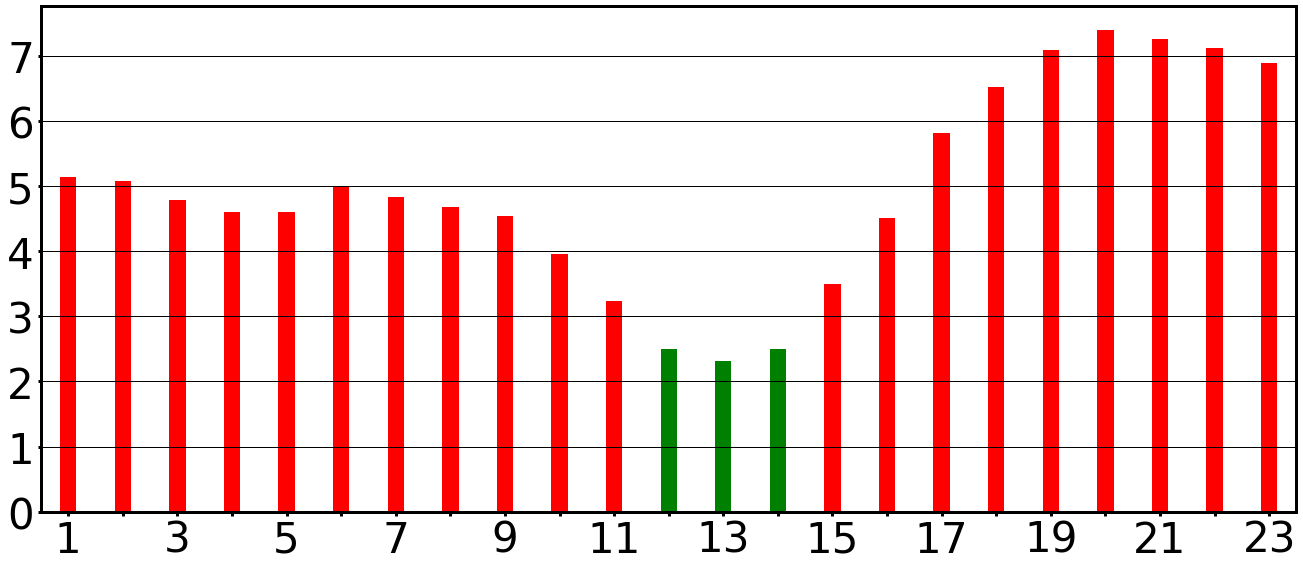

In [117]:
%matplotlib inline
import io
from PIL import Image
import utils
import configparser

CONFIG_FILENAME = 'config.ini'

with open(CONFIG_FILENAME) as f:
    config_parser = configparser.ConfigParser()
    config_parser.read_file(f)
    logger.info('Config: %s', config_parser.items('general'))
    config = config_parser['general']
    fonts = utils.get_fonts(config)

vsize = 448-200
hsize = 600
dpi = 80
factor=3

fig = plt.figure(figsize=((hsize/dpi*factor,vsize/dpi*factor)), frameon=False)
ax = plt.subplot()
vals = df_future.Price
hours = df_future.Hour
colors = ["green" if i < 3 else "red" for i in vals]
barplot = ax.bar(df_future.Hour, df_future.Price, 0.3, color=colors)
ax.set_xlim([min(df_future.Hour)-0.5, max(df_future.Hour)+0.5])
ax.set_xticks(hours)
ax.grid(axis='y', linewidth=1, color='k')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

# increase tick width
ax.tick_params(width=3)

for tick in ax.get_xticklabels():
    tick.set_fontname('barlow-condensed')
    tick.set_fontsize(14*factor)
for tick in ax.get_xticklabels()[1::2]:
    tick.set_visible(False)
for tick in ax.get_yticklabels():
    tick.set_fontname('barlow-condensed')
    tick.set_fontsize(14*factor)
plt.show()



In [89]:
np.max(df_future.Hour)

23

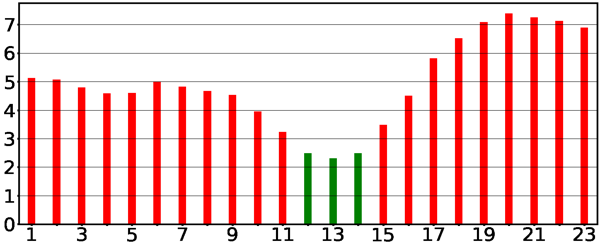

In [118]:
buf = io.BytesIO()

fig.savefig(buf, format="png", dpi=dpi,bbox_inches='tight')
fig.savefig('elpanel_plot.png', format="png", dpi=dpi)
buf.seek(0)
plot_image = Image.open(buf).convert("RGB")
newsize = (hsize, vsize)
im1 = plot_image.resize(newsize)
display(im1)
buf.close()

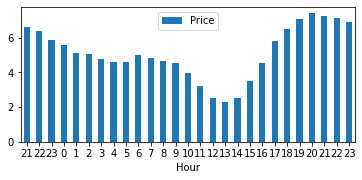

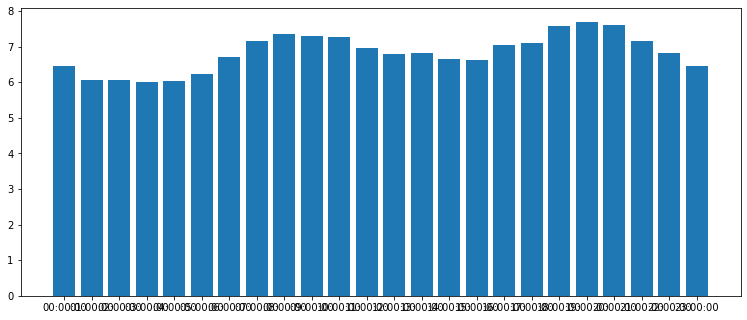

In [196]:
fig = plt.figure(figsize=[10,4])
ax = fig.add_axes([0,0,1,1])
ax.bar(df_future.Time,df_future.Price)
plt.show()